In [112]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.decomposition import PCA


CARGA DE DATASET DE ENTRENAMIENTO

In [2]:
data_train = pd.read_csv('properties_colombia_train.csv')

DAR FORMATO A DATOS:
<p>start_date ->date -> to_ordinal </p>
<p>end_date -> date -> to_ordinal </p>
<p>created_on -> date -> to_ordinal </p>


In [3]:
# Para verificar cantidad de datos con año 2020, 2021 y 9999 
#df=data_train.end_date.dropna().str.split('-', expand=True)
#df = df.astype({0:int , 1:int, 2:int})
#df.loc[:,0].value_counts()

In [4]:
# Asigna None a fechas que comienzan con 9999-
data_train['end_date'] = data_train['end_date'].map(lambda x: None if x.split('-')[0]=='9999' else x) 

In [5]:
# Conversion de tipo de dato a date de las tres columnas de con fechas
data_train['start_date'] = pd.to_datetime(data_train['start_date']) 
data_train['created_on'] = pd.to_datetime(data_train['created_on']) 
data_train['end_date'] = pd.to_datetime(data_train['end_date']) 


In [6]:
#evaluar consistencia de columnas con fechas
#data_train[['start_date', 'end_date', 'created_on']].describe(datetime_is_numeric=True)

In [7]:
#conversion de las fechas de date a ordinal 
import datetime as dt
data_train['start_date'] =  data_train['start_date'].map(dt.datetime.toordinal)
data_train['created_on'] =  data_train['created_on'].map(dt.datetime.toordinal)
data_train['end_date'] =  data_train['end_date'].map(dt.datetime.toordinal)


MANEJO DE INCONSISTENCIAS

Eliminación de datos con precio en dólares

In [8]:
ind_dolar=data_train[data_train.currency=='USD'].index.tolist()
data_train.drop(index=ind_dolar , inplace=True)

Eliminación de nulos basados en columnas 'currency', 'price'

In [9]:
data_train.dropna(subset=['price','currency'], inplace=True) # se eliminan 67 filas que no tienen price o currency

Eliminación de valores de lat() y lon() fuera de rango

In [10]:
# Visualizar lat y lon fuera de rango
#data_train[['lat' , 'lon','title', 'description', 'property_type', 'l2', 'l3', 'price']][(data_train.lat<-4.2) | (data_train.lat>13.4)] # visualizar lat fuera de rango
#data_train[['lon' , 'l2', 'l3']][(data_train.lon<-81.74) | (data_train.lon>-67)] # visualizar lon fuera de rango

In [11]:
# Eliminar lat y lon fuera de rango
ind_out_of_range =data_train.index[(data_train.lat<-4.2) | (data_train.lat>13.4)].tolist() 
data_train.drop(index=ind_out_of_range, inplace=True)

In [12]:
# comprobación de lat y lon
#data_train[['lat','lon']].describe()

Identificacion y eliminación de columnas que no dan información:

In [13]:
# verificación de diferencias entre start_date created_on
#dif_fecha=data_train.start_date - data_train.created_on #calcula diferencia entre start_date y created_on
#dif_fecha.value_counts() # todas las diferencias son 0 luego son dos columnas exactamente iguales

In [14]:
# verificación de utilidad de columna geometry
#data_train[['lat','lon','geometry']].isnull().value_counts()# cuenta la cantidad de conbinaciones de nulos que hay entre lat, lon y geometry
#temp=data_train[['lat','lon','geometry']][data_train.lat.isnull()] #crea dataframe con lat==null
#temp.geometry.value_counts() # se verifica  que todas las filas con lat==null tambien geometry=='POINT EMPTY'

In [15]:

columnas_descartables = ['id','Unnamed: 0','created_on','l1', 'operation_type', 'ad_type', 'price_period','currency', 'geometry']
data_train.drop(columns=columnas_descartables, inplace=True) # eliminación de columnas que no agregan info

Eliminación de duplicados, se crean dos datasets:
- data_train_sf: se crea eliminando duplicados de data_train sin las columnas start_date y end_date
- data_train: se crea eliminando duplicados de data_train

In [16]:
# la eliminación de duplicados sin tener en cuenta fechas
#data_train.drop(columns=['start_date','end_date']).duplicated().value_counts() # contar catidad de duplicados
data_train_sf= data_train.drop(columns=['start_date','end_date']).drop_duplicates() #se eliminan 74229 filas
data_train_sf.reset_index(inplace=True, drop=True) # para no tener inconvenientes con concatenaciones horizontales posteriores

In [17]:
#verificación de cantidad de duplicados según columnas incluidas
#data_train.loc[:,['title','description','price', 'l2','l3','l4','l5','l6','property_type']].duplicated().value_counts()

In [18]:
# elimina duplicados de data_train teniendo en cuenta todas las columnas
data_train.drop_duplicates(inplace=True) 
data_train.reset_index(inplace=True, drop=True)

PREPROCESAMIENTO

EDA (selección de features)

- creación de target

"plt.figure(figsize=(18,4))\nsns.histplot(x=data_train.price[data_train.property_type=='Apartamento'])\nplt.xlim(0,2000000000)"

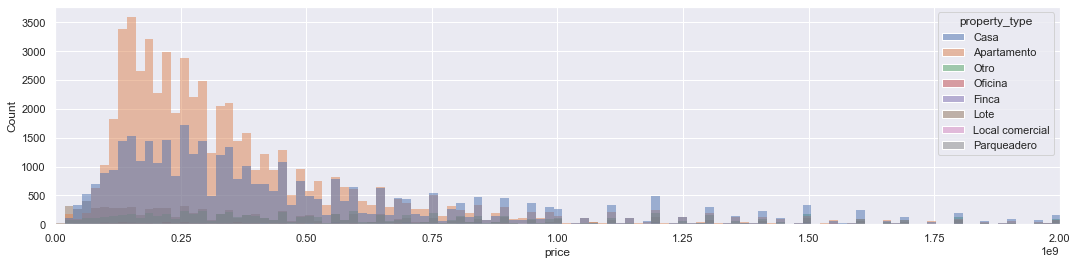

In [22]:
"""plt.figure(figsize=(18,4))
sns.histplot(data=data_train_sf, x='price', hue='property_type')
plt.xlim(0,2000000000)"""
"""plt.figure(figsize=(18,4))
sns.histplot(x=data_train.price[data_train.property_type=='Apartamento'])
plt.xlim(0,2000000000)"""

In [27]:
price_mean = data_train.price.mean()
data_train['target'] = data_train.price.map(lambda x: 1 if x>= price_mean else 0) # creacion de target en data_train
data_train_sf['target'] = data_train_sf.price.map(lambda x: 1 if x>= price_mean else 0) #creación de target en data_train_sf

- verificación balanceo

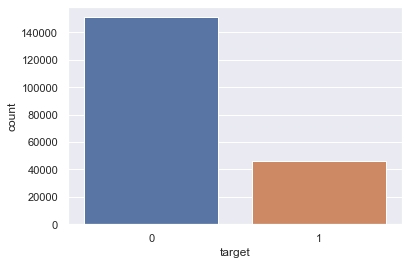

In [226]:
sns.countplot(x='target', data=data_train ) # grafica cantidad de baratos:0 y caros:1 
plt.show()
# se considera que la relación positivo negativos de aprox. 24/76 es aceptable 

- ver correlación: corr() , pairplot()

In [28]:
# se crea matriz de correlación entre variables numericas
corr = data_train[['start_date', 'end_date', 'lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price','target']].corr(method='pearson')

<AxesSubplot:>

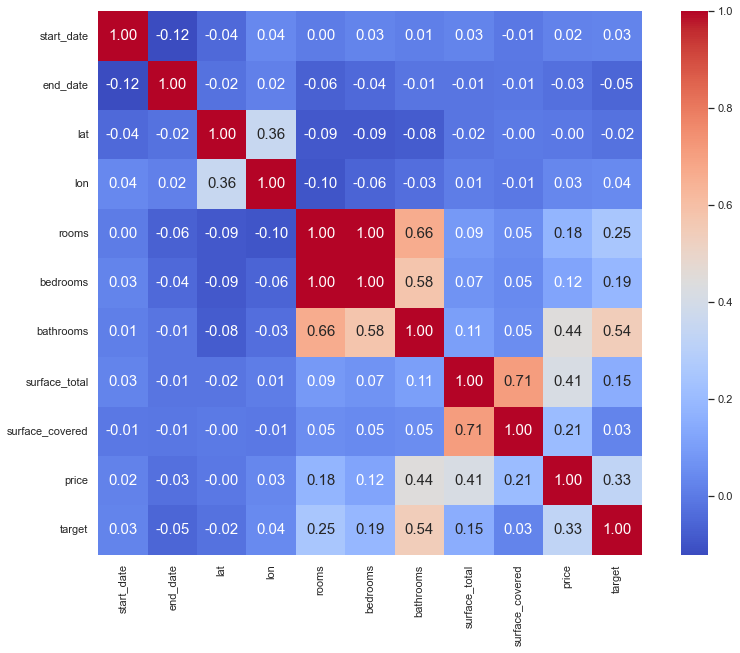

In [29]:

plt.figure(figsize=(14,10))
cols_heatmap=['start_date', 'end_date', 'lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price','target']
sns.heatmap(corr, square=True, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={'size':15}, xticklabels=cols_heatmap, yticklabels=cols_heatmap)

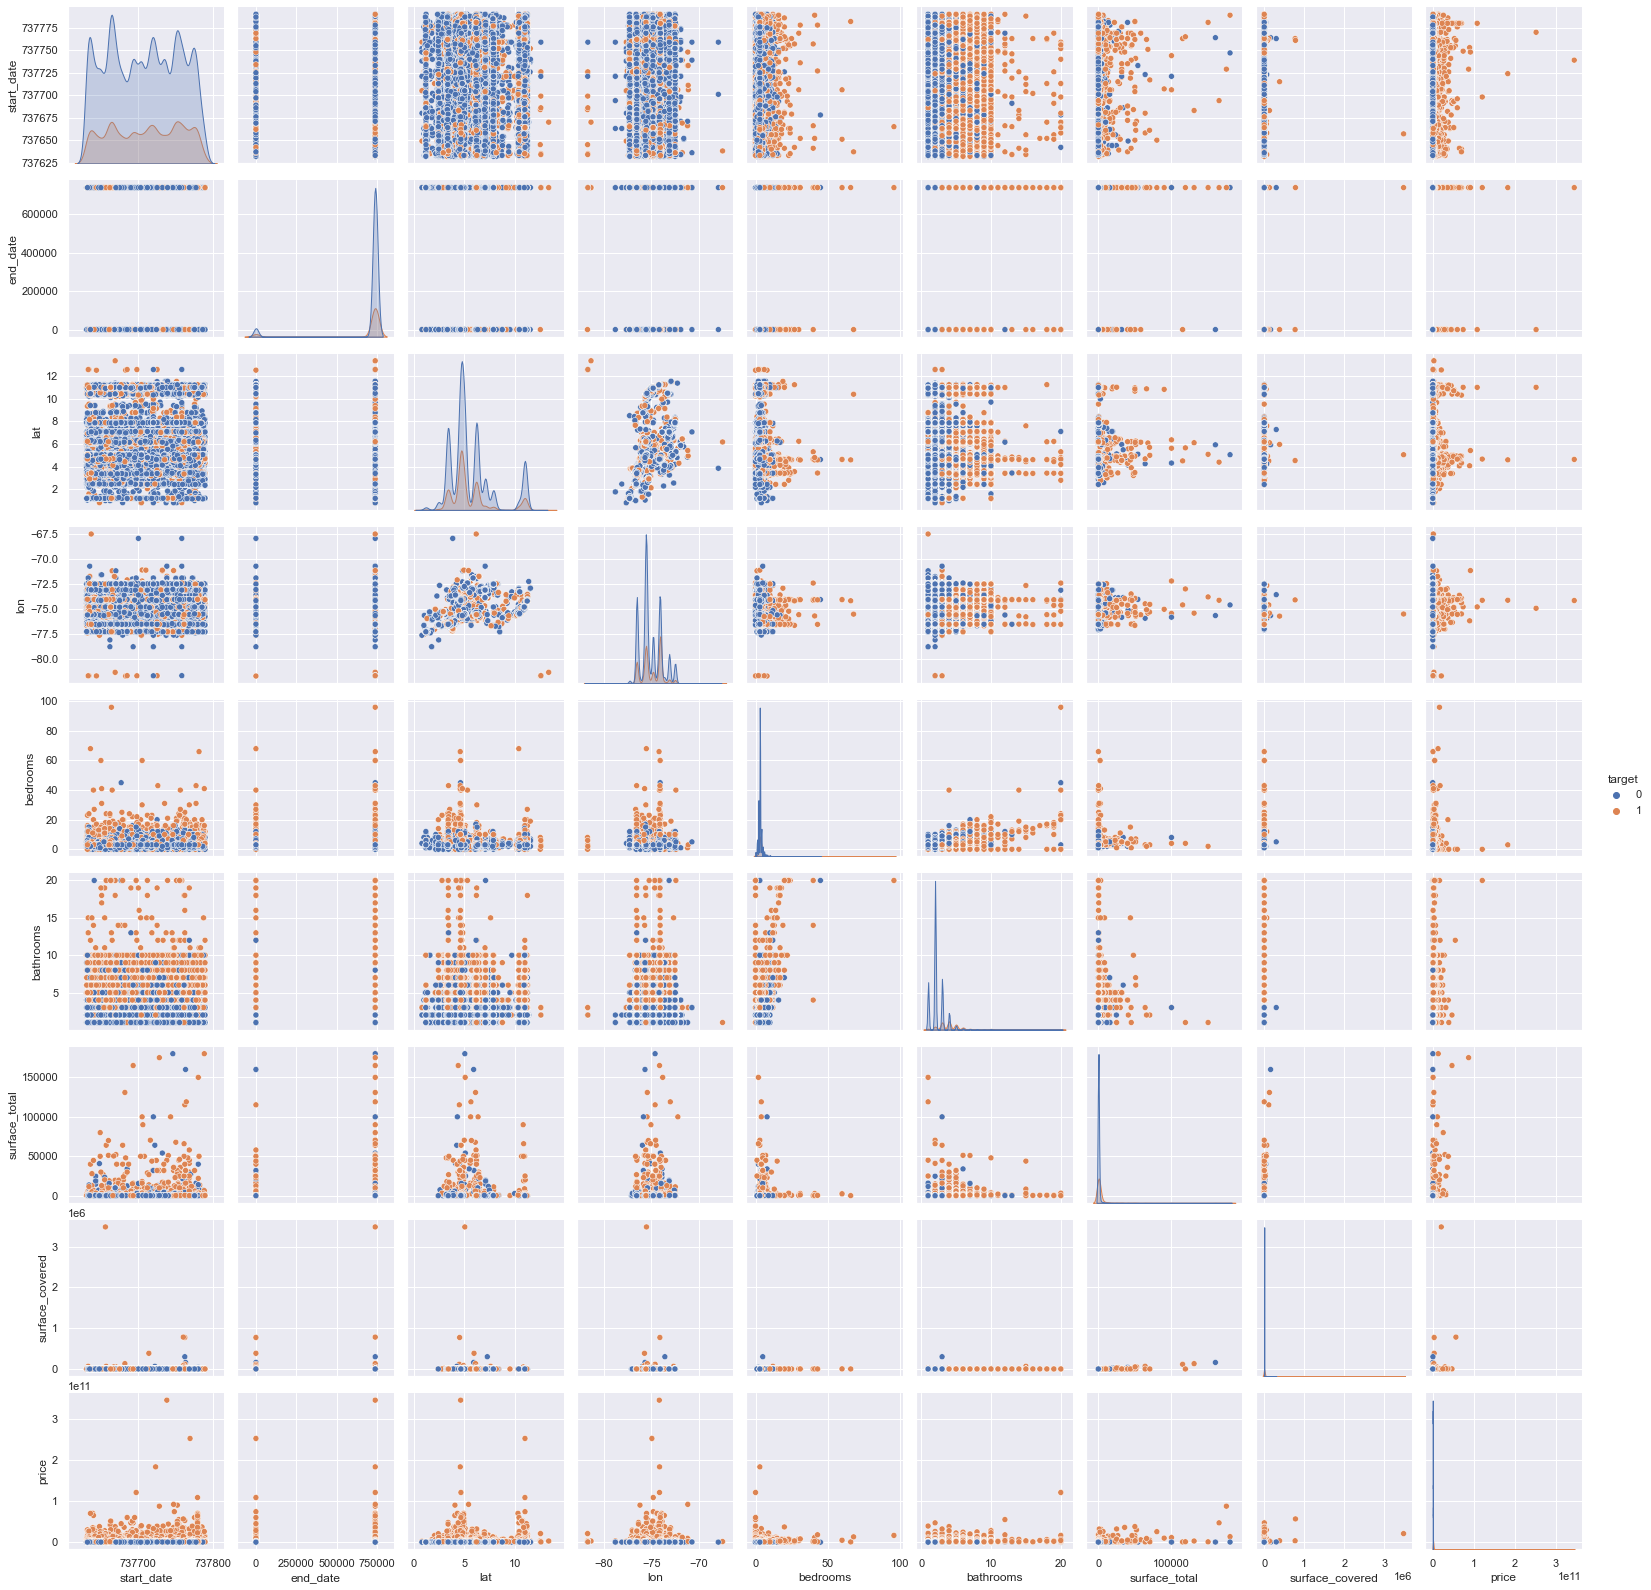

In [229]:
sns.pairplot(data=data_train[['start_date', 'end_date', 'lat', 'lon', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered','price' ,'target']], hue='target')

hasta aquí se seleccionan los features surface_total, bathrooms y rooms 

- Imputación de valores faltantes para selección de features con KBest()

Codificación de variables categóricas nominales relacionadas con ubicacion(l2, l3, l4) con get_dummies() para imputacion de valores faltantes de lat y lon

In [37]:
dummies = pd.get_dummies(data_train_sf, columns=['l2','l3','l4','property_type']) #obtener dummies de ubicaciones y property_type
dummies.drop(columns=['lat', 'lon', 'l5', 'l6', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price', 'title', 'description'] , inplace=True)

Reducción de dimensionalidad de los dummies de l1,l2, l3, property_type usando PCA 

In [ ]:
from sklearn.decomposition import PCA #reducen de aprox. 400 dummies a 20 columnas
pca = PCA(n_components=20)
dummies_reduc=pca.fit_transform(dummies)

In [ ]:
dummies_reduc = pd.DataFrame(dummies_reduc) 

In [ ]:
dummies_reduc= pd.concat([data_train_sf[['lat','lon']],dummies_reduc], axis=1) # concateno 20 dummies con lat y lon

Imputacion de lat y lon

In [ ]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3, add_indicator=True)
latlon_filled_array = imputer.fit_transform(dummies_reduc)

c:\Users\jcgut\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\jcgut\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [ ]:
latlon_filled_array= np.delete(latlon_filled_array,list(range(2,23)),axis=1) #elimino dummies del array

In [ ]:

latlon_filledcolumns=['lat','lon','imputed'] #convierto array de lat y lon filled a dataframe
latlon_filled = pd.DataFrame(latlon_filled_array, columns=latlon_filledcolumns)
#latlon_filled.head()

,lat,lon,imputed
0,6.203000,-75.572000,0.0
1,4.722748,-74.073115,0.0
2,4.709000,-74.030000,0.0
3,7.114019,-73.114067,1.0
4,6.233673,-75.576800,1.0


In [ ]:
#asigno columnas de lat lon imputadas a el dataframe sin fechas
data_train_sf['lat']=latlon_filled['lat']
data_train_sf['lon']=latlon_filled['lon']
data_train_sf.insert(2,"loc_mis_ind", latlon_filled['imputed']) # agrega indicador de imputación

Imputacion de bathrooms, bedrooms, rooms, surface_total, surface_covered

In [ ]:
#obtengo dummies de property_type para rellenar rooms, bedrooms, bathrooms, surface_total, surface_covered
dummies = pd.get_dummies(data_train_sf, columns=['property_type'])
dummies.drop(columns=['lat', 'lon','loc_mis_ind','l2','l3','l4', 'l5', 'l6', 'price', 'title', 'description'] , inplace=True)

In [ ]:
# instancio, fiteo y transformación para obtener array con columnas llenas
imputer_rooms = KNNImputer(n_neighbors=3, add_indicator=True)
rooms_filled_array = imputer_rooms.fit_transform(dummies)

In [ ]:
#elimino dummies de array que resulta de la imputación
rooms_filled_array = np.delete(rooms_filled_array,list(range(5,13)),axis=1)

In [ ]:
# corvierto a dataframe al arraycorregido resultado de la imputación
rooms_filledcolumns=[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered','ro_mis_ind','br_mis_ind','ba_mis_ind','st_mis_ind','sc_mis_ind']]
rooms_filled = pd.DataFrame(rooms_filled_array, columns=rooms_filledcolumns)
#rooms_filled.head()

,rooms,bedrooms,bathrooms,surface_total,surface_covered,ro_mis_ind,br_mis_ind,ba_mis_ind,st_mis_ind,sc_mis_ind
0,4.0,4.000000,4.0,163.333333,198.333333,1.0,0.0,0.0,1.0,1.0
1,3.0,3.000000,2.0,86.666667,60.000000,1.0,0.0,0.0,1.0,1.0
2,4.0,4.000000,2.0,953.333333,114.666667,1.0,1.0,0.0,1.0,1.0
3,4.0,4.000000,1.0,422.666667,654.333333,1.0,1.0,0.0,1.0,1.0
4,3.0,3.666667,2.0,85.333333,86.000000,1.0,1.0,0.0,1.0,1.0


In [ ]:
# reemplazo columnas con columnas llenas
data_train_sf['rooms']=rooms_filled['rooms']
data_train_sf['bedrooms']=rooms_filled['bedrooms']
data_train_sf['bathrooms']=rooms_filled['bathrooms']
data_train_sf['surface_total']=rooms_filled['surface_total']
data_train_sf['surface_covered']=rooms_filled['surface_covered']

data_train_sf = pd.concat([data_train_sf , rooms_filled[['ro_mis_ind', 'br_mis_ind', 'ba_mis_ind', 'st_mis_ind', 'sc_mis_ind']]], axis=1) # agrego indicadores de imputación

In [ ]:
#exporto data_train_sf a csv para no tener que volver a correr la imputación ya que toma mucho tiempo
data_train_sf.to_csv('data_train_sf.csv', index=False)

verifico correlación con el target de columnas llenas

In [ ]:
corr_sf_filled = data_train_sf[['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price','target']].corr(method='pearson')

<AxesSubplot:>

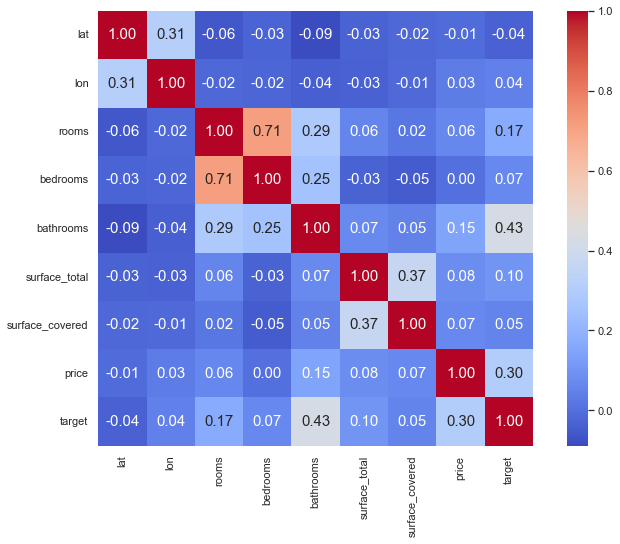

In [40]:
plt.figure(figsize=(12,8))
cols_heatmap=['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price','target']
sns.heatmap(corr_sf_filled, square=True, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={'size':15}, xticklabels=cols_heatmap, yticklabels=cols_heatmap)

- Codificación de property_type para modelos de clasificación

In [43]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data_train_sf['property_type_le'] = le.fit_transform(data_train_sf['property_type'])

- seleccion de features con sklearn.feature_selection.SelectKBest

In [44]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import mutual_info_classif

In [45]:
# se instancias 
selector_price= SelectKBest(mutual_info_regression, k=6)
selector_target= SelectKBest(mutual_info_classif, k=6)

In [137]:
X= data_train_sf[[ 'lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered','property_type_le']].values
y_price = data_train_sf[['price']].values
y_target = data_train_sf[['target']].values.reshape(-1,)

In [47]:
selector_price.fit(X,y_price)
selector_target.fit(X,y_target)

c:\Users\jcgut\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jcgut\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SelectKBest(k=6,
            score_func=<function mutual_info_classif at 0x00000242A0088B80>)

In [50]:
# se observan los score de los features ingresados
print( [ 'lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered','property_type_le'])
print( selector_price.scores_)
print( selector_target.scores_)


['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'property_type_le']
[0.57668781 0.53669277 0.09676435 0.13952441 0.28446033 0.42073697
 0.41397169 0.11931614]
[0.12643952 0.11764066 0.03452053 0.04797912 0.1080429  0.16242188
 0.15887713 0.0373141 ]


APLICACIÓN DE MODELOS

Entrenamiento

In [ ]:
# rellenando faltantes con la media
filldict={'lat':data_train.lat.mean(), 
        'lon':data_train.lon.mean(), 
        'rooms':data_train.rooms.mean(), 
        'bedrooms':data_train.bedrooms.mean(), 
        'bathrooms':data_train.bathrooms.mean(), 
        'surface_total':data_train.surface_total.mean(), 
        'surface_covered':data_train.surface_covered.mean()}
X=data_train.drop(columns=['start_date','end_date']).drop_duplicates()[['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']].fillna(filldict).values

`HistGradientBoostingClassifier()`

In [130]:
X= data_train_sf[[ 'lat', 'lon', 'bathrooms', 'surface_total']].values

In [131]:
from sklearn.ensemble import HistGradientBoostingClassifier
clf_HGBC=HistGradientBoostingClassifier(scoring='recall' ).fit(X,y_target)

In [132]:
y_train_pred_HGBC = clf_HGBC.predict(X)
print('recall:', recall_score(y_target, y_train_pred_HGBC))
print('accuracy', accuracy_score(y_target, y_train_pred_HGBC))

recall: 0.6356697870119704
accuracy 0.8620043329032886


`RandomForestClassifier()`

In [133]:
X= data_train_sf[[ 'lat', 'lon', 'bathrooms', 'surface_covered']].values
y_target = data_train_sf[['target']].values

In [134]:
# instanciación y fiteo
from sklearn.ensemble import RandomForestClassifier
clf_RFC = RandomForestClassifier(n_estimators=100, max_features='sqrt', n_jobs=-1, oob_score = True, random_state = 42)
clf_RFC.fit(X, y_target)

C:\Users\jcgut\AppData\Local\Temp\ipykernel_30816\3691213844.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf_RFC.fit(X, y_target)


RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42)

In [135]:
clf_RFC.feature_importances_ #importancias de cada feature

array([0.30912141, 0.29880339, 0.14589433, 0.24618088])

In [136]:
# Predecimos
y_train_pred_RF = clf_RFC.predict(X)
# Evaluamos
print('recall:', recall_score(y_target, y_train_pred_RF))
print('accuracy', accuracy_score(y_target, y_train_pred_RF))

recall: 0.9347010665709906
accuracy 0.9743677125678537


`Boosting()`

In [138]:
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier

clf_xgb = xgb.XGBClassifier(n_estimators=150,
                            seed=42, use_label_encoder= False)
clf_xgb.fit(X, y_target)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=150,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [139]:
# Predecimos
y_train_pred_xgb = clf_xgb.predict(X)
# Evaluamos
print('Accuracy en train:', accuracy_score(y_target, y_train_pred_xgb))
print('Accuracy en test:', accuracy_score(y_target, y_train_pred_xgb))

Accuracy en train: 0.8905657927833629
Accuracy en test: 0.8905657927833629


 `BaggingClassifier()`   `AdaBoostClassifier()` `LogisticRegression()` `svm.SVC-89`  `XGBClassifier()` `` ``

PREPARACIÓN DE DATASET DE TESTEO: se realiza todo el preprocesamiento que se realizó al dataframe de entrenamiento

In [261]:
data_test = pd.read_csv('properties_colombia_test.csv') # se carga el dataset de testeo

In [262]:
columnas_descartables = ['id','Unnamed: 0','start_date' ,'end_date','created_on','l1', 'operation_type', 'ad_type', 'price_period','currency', 'geometry']
data_test.drop(columns=columnas_descartables, inplace=True) # eliminación de columnas que no agregan info

In [264]:
dummies = pd.get_dummies(data_test, columns=['l2','l3','l4','property_type']) #obtener dummies de l ubicaciones y property_type
dummies.drop(columns=['lat', 'lon','l5', 'l6', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'title', 'description'] , inplace=True)

In [268]:
# reduccion de dimensiones de dummies
from sklearn.decomposition import PCA #reducen de aprox 400 dummies a 20 columnas
pca = PCA(n_components=20)
dummies_reduc=pca.fit_transform(dummies)
dummies_reduc = pd.DataFrame(dummies_reduc)
dummies_reduc= pd.concat([data_test[['lat','lon']],dummies_reduc], axis=1) 

In [270]:
from sklearn.impute import KNNImputer # imputacion de lat y lon con los 20 dummies
imputer = KNNImputer(n_neighbors=3, add_indicator=True)
latlon_filled_array = imputer.fit_transform(dummies_reduc)

c:\Users\jcgut\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\jcgut\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [271]:
latlon_filled_array= np.delete(latlon_filled_array,list(range(2,23)),axis=1) #elimino dummies del array
latlon_filledcolumns=['lat','lon','imputed'] #convierto array de lat y lon filled a dataframe
latlon_filled = pd.DataFrame(latlon_filled_array, columns=latlon_filledcolumns)

In [277]:
#asigno columnas de lat lon imputadas a el dataframe principal(data_test)
data_test['lat']=latlon_filled['lat']
data_test['lon']=latlon_filled['lon']
data_test.insert(2,"loc_mis_ind", latlon_filled['imputed'])

In [280]:
#obtengo dummies de property_type para rellenar rooms, bedrooms, bathrooms, surface_total, surface_covered
dummies = pd.get_dummies(data_test, columns=['property_type'])
dummies.drop(columns=['lat', 'lon','loc_mis_ind','l2','l3','l4', 'l5', 'l6', 'title', 'description'] , inplace=True)

In [282]:
# imputar rooms, bedrooms, bathrooms, surface_total, surface_covered
imputer_rooms = KNNImputer(n_neighbors=3, add_indicator=True)
rooms_filled_array = imputer_rooms.fit_transform(dummies)

In [284]:
# elimino dummies del array que resulta de la imputación
rooms_filled_array = np.delete(rooms_filled_array,list(range(5,13)),axis=1)
# convierto a dataframe al arraycorregido resultado de la imputación
rooms_filledcolumns=[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered','ro_mis_ind','br_mis_ind','ba_mis_ind','st_mis_ind','sc_mis_ind']]
rooms_filled = pd.DataFrame(rooms_filled_array, columns=rooms_filledcolumns)

In [285]:
# reemplazo columnas con valores de columnas llenas
data_test['rooms']=rooms_filled['rooms']
data_test['bedrooms']=rooms_filled['bedrooms']
data_test['bathrooms']=rooms_filled['bathrooms']
data_test['surface_total']=rooms_filled['surface_total']
data_test['surface_covered']=rooms_filled['surface_covered']

In [ ]:
# se seleccionan las features a utilizar con el dataset de testeo
X_test= data_test[[ 'lat', 'lon', 'bathrooms', 'surface_covered']].values

Predicción en dataset test y exportación a csv

In [295]:
y_test_pred_HGBC= clf_HGBC.predict(X_test) # prediccion con modelo HistGradientBoostingClassifie

In [296]:
y_test_pred_RF = clf_RFC.predict(X_test) # prediccion con modelo

In [297]:
y_test_pred=pd.DataFrame(y_test_pred_RF, columns=['pred'] )

In [298]:
y_test_pred.to_csv('CesarG2022.csv', index=False)